In [1]:
import os
import tellurium as te
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
with open('results/240829_M7/logs_ABR2.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

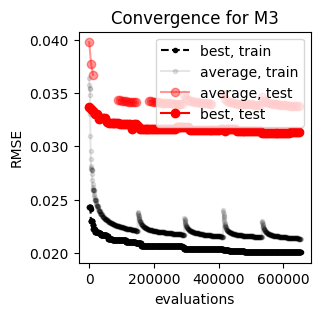

In [4]:
results = [np.concatenate(l,axis=0) for l in logs]
plt.figure(figsize=(3,3))
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,2],'.k--', label = 'best, train') for res in results]
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,4],'.k-', alpha = 0.1, label = 'average, train') for res in results]
# plt.xscale('log')

test_evals = np.arange(1,len(np.squeeze(np.array(test_fit)))*10*600,10*600)
plt.plot(test_evals, np.squeeze(np.array(test_fit)).mean(axis=1),'or-', alpha = 0.4, label = 'average, test')
plt.plot(test_evals, np.squeeze(np.array(test_fit)).min(axis=1),'or-', label = 'best, test')

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(0.02,0.055)
plt.ylabel('RMSE')
plt.xlabel('evaluations')
plt.title('Convergence for M3')  
plt.legend(loc='upper right')
# plt.text(1800000, 19, 'n = 1 \np = 600');

In [5]:
with open('results/240829_M7/bounds_ABR.dat', 'rb') as file:
    all_lower,all_upper = pickle.load(file)

In [6]:
len(all_lower)

5

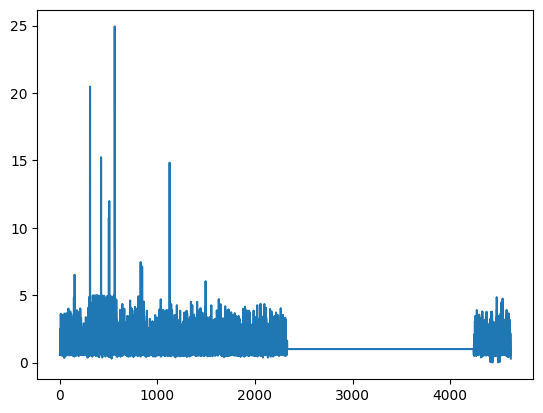

In [8]:
plt.plot(all_upper[-1]/all_upper[0])

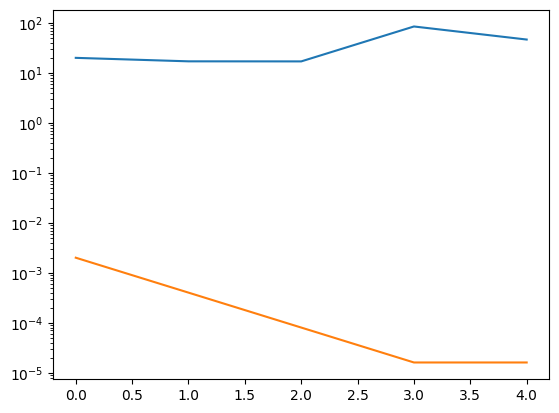

In [9]:
plt.plot(np.array(all_upper)[:,100])
plt.plot(np.array(all_lower)[:,100])
plt.yscale('log')

In [28]:
all_train = []
all_test = []
all_params = []
all_enzymes = []
all_rxns = []
all_metabolites = []

In [45]:
modelfile = os.getcwd()+'/models/240828_M3.sbml'
r = te.loadSBMLModel(modelfile)

# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r.getGlobalParameterIds() if 'Kcat_V' in p]
keq_labels = [p for p in r.getGlobalParameterIds() if 'Keq' in p]
km_labels = [p for p in r.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r.getGlobalParameterIds() if 'Gnc' in p]
Gc_labels = [p for p in r.getGlobalParameterIds() if 'Gc' in p ]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+150:sbml.find('<initialAssignment symbol="'+s+'">')+150+len(s)]).split(' ')[0] for s in metabolites] if 'v' in v]
heterologous_expression = [p for p in r.getGlobalParameterIds() if 'rel' in p][1:]

parameter_labels = kcat_labels + keq_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + metabolites_labels + heterologous_expression
parameter_labels.append('rel0') # what are good bounds for this?

In [46]:
all_params.append(len(parameter_labels))
all_enzymes.append(len(pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M3.csv')['EC'].unique()))
all_rxns.append(r.getNumReactions())
all_metabolites.append(len(metabolites))

In [47]:
with open('results/240829_M3/logs_3AB.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

In [ ]:
all_train.append([np.concatenate(l,axis=0) for l in logs][0][-1,2])
all_test.append(np.squeeze(np.array(test_fit)).min(axis=1)[-1])
# all_test.append(test_fit[-1][0][0].min())

Text(-1, 4.9, 'Parameters')

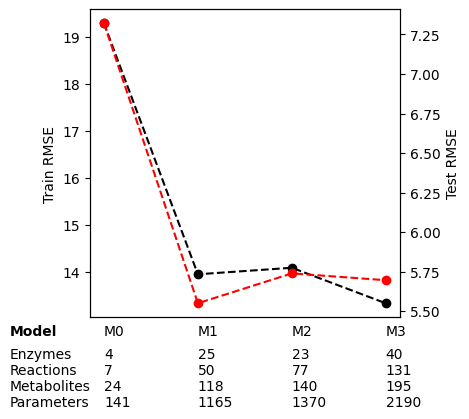

In [95]:
plt.figure(figsize=(4,4))
plt.plot(all_train,'ko--')
plt.ylabel('Train RMSE')

# Create a twin axes
ax2 = plt.twinx()

# Plot the test results on the twin axes
ax2.plot(all_test, 'ro--')
ax2.set_ylabel('Test RMSE')
plt.xlabel('Model')
plt.xticks([])

[plt.text(i, 5.35, str(k)) for i,k in enumerate(['M0','M1','M2','M3'])]
[plt.text(i, 5.20, str(k)) for i,k in enumerate(all_enzymes)]
[plt.text(i, 5.10, str(k)) for i,k in enumerate(all_rxns)]
[plt.text(i, 5.00, str(k)) for i,k in enumerate(all_metabolites)]
[plt.text(i, 4.90, str(k)) for i,k in enumerate(all_params)]

plt.text(-1, 5.35, 'Model', fontweight='bold')
plt.text(-1, 5.20, 'Enzymes')
plt.text(-1, 5.10, 'Reactions')
plt.text(-1, 5.00, 'Metabolites')
plt.text(-1, 4.90, 'Parameters')

In [104]:
with open('results/240829_M3/240828_train_myprob.obj', 'rb') as file:
    train_myprob = pickle.load(file)

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:503: RuntimeWarning:

divide by zero encountered in divide

/mmfs1/gscratch/cheme/dalba/repos/ECFERS/src/fitting/pygmo_problems.py:503: RuntimeWarning:

invalid value encountered in divide



Text(0.5, 0, 'RMSE')

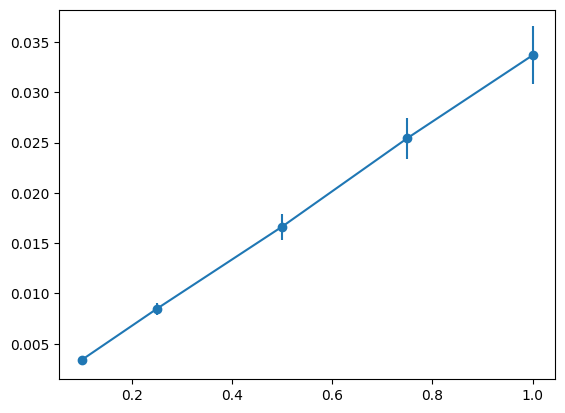

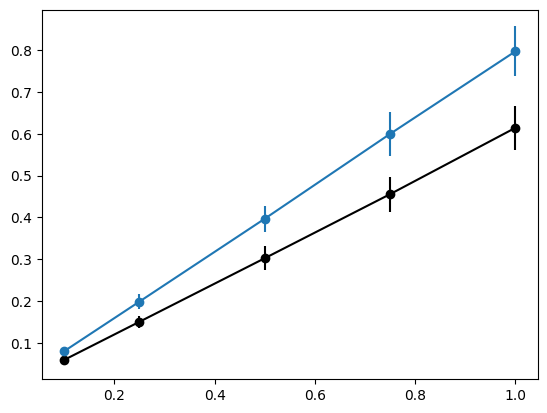

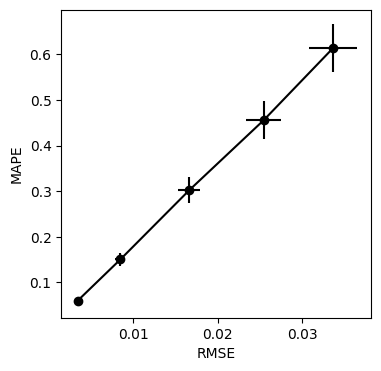

In [208]:
std = 0.5

m_ses = []
s_ses = []
m_saes = []
s_saes = []
m_usaes = []
s_usaes = []

for std in [0.1,0.25,0.5,0.75,1]:
    se = [np.nanmean([np.nanmean(train_myprob._residual(train_myprob.data[0][k]*(np.random.normal(1,std,train_myprob.data[0][k].shape)),train_myprob.data[0][k],train_myprob.data_weights[0][k],k,train_myprob.model_stuff[0])) for k in train_myprob.data[0].keys()]) for _ in range(100)]
    m_se = np.nanmean(se)
    s_se = np.nanstd(se)
    m_ses.append(m_se)
    s_ses.append(s_se)

    sae = [np.nanmean([np.nanmean(np.abs(train_myprob.data[0][k]*(np.random.normal(1,std,train_myprob.data[0][k].shape)) - train_myprob.data[0][k])/train_myprob.data[0][k]*train_myprob.data_weights[0][k]) for k in train_myprob.data[0].keys()]) for _ in range(100)]
    m_sae = np.nanmean(sae)
    s_sae = np.nanstd(sae)
    m_saes.append(m_sae)
    s_saes.append(s_sae)

    usae = [np.nanmean([np.nanmean(np.abs(train_myprob.data[0][k]*(np.random.normal(1,std,train_myprob.data[0][k].shape)) - train_myprob.data[0][k])/train_myprob.data[0][k]) for k in train_myprob.data[0].keys()]) for _ in range(100)]
    m_usae = np.nanmean(usae)
    s_usae = np.nanstd(usae)
    m_usaes.append(m_usae)
    s_usaes.append(s_usae)

plt.errorbar([0.1,0.25,0.5,0.75,1],m_ses,yerr=s_ses,fmt='o-')
plt.figure()
plt.errorbar([0.1,0.25,0.5,0.75,1],m_saes,yerr=s_saes,fmt='ko-')
plt.errorbar([0.1,0.25,0.5,0.75,1],m_usaes,yerr=s_usaes,fmt='o-')

plt.figure(figsize=(4,4))
plt.errorbar(m_ses,xerr=s_ses, y=m_saes,yerr=s_saes, fmt='ko-')
plt.ylabel('MAPE')
plt.xlabel('RMSE')

In [233]:
with open('results/240829_M3/checkpoint_ABR2_2.dat', 'rb') as file:
    pops19 = pickle.load(file)

(0.0, 200.0)

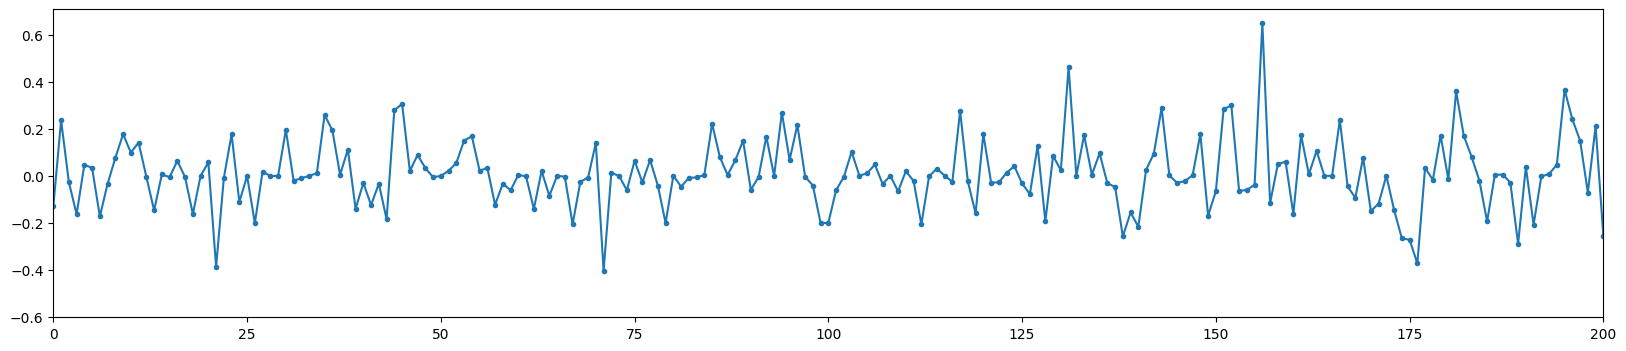

In [268]:
plt.figure(figsize=(20,4))
plt.errorbar(range(len(pops19[0].get_x().T)),(pops19[0].get_x()-pops18[0].get_x())[577,:], fmt='.-')
plt.xlim(0,200)

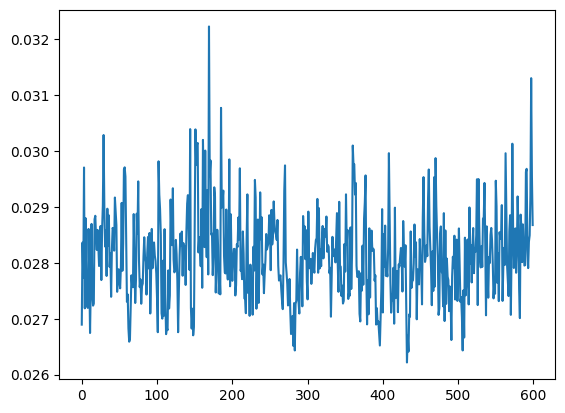

In [288]:
plt.plot(pops19[0].get_f()[np.argsort(np.sum(np.abs(pops19[0].get_x()-pops18[0].get_x()),1)),:])

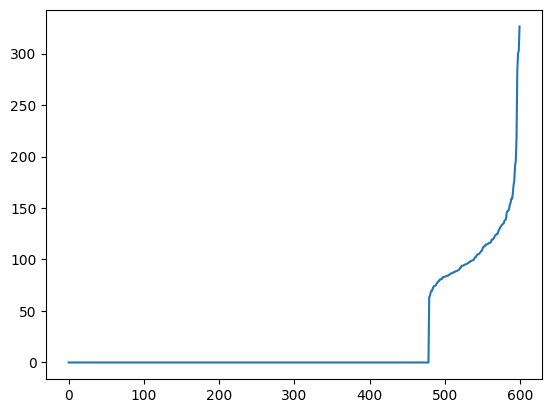

In [282]:
plt.plot(np.sort(np.sum(np.abs(pops19[0].get_x()-pops18[0].get_x()),1)))

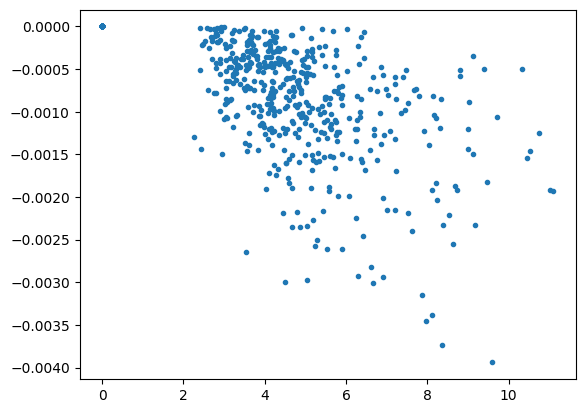

In [277]:
plt.plot(np.sum((pops19[0].get_x()-pops12[0].get_x())**2,1)**0.5, pops19[0].get_f()-pops12[0].get_f(),'.')

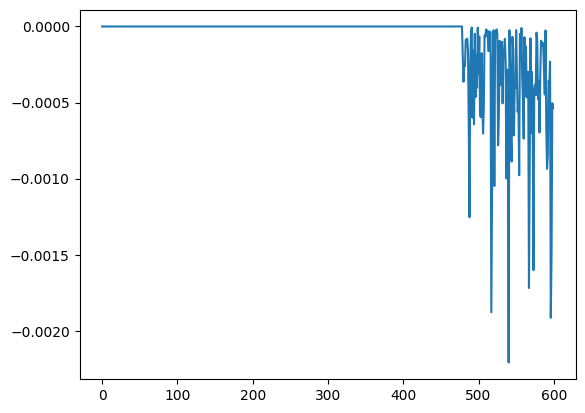

In [289]:
plt.plot((pops19[0].get_f()-pops18[0].get_f())[np.argsort(np.sum(np.abs(pops19[0].get_x()-pops18[0].get_x()),1)),:])

In [297]:
np.argsort(pops19[0].get_f()[:,0])[:6]

array([199, 197, 116, 195, 114,  44, 394, 397, 392, 393, 198, 550, 342,
       111,  45, 383, 338, 316, 344, 548])

(100.0, 150.0)

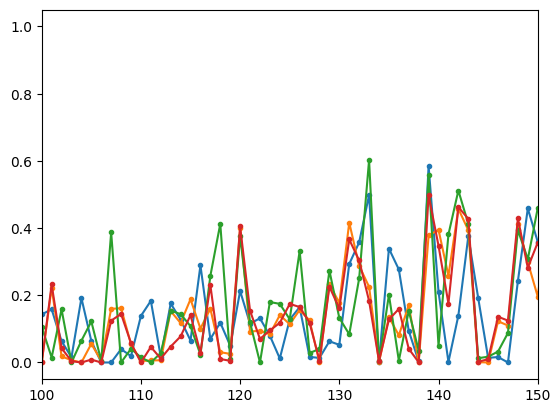

In [312]:
plt.plot(pops12[0].get_x()[np.argsort(pops12[0].get_f()[:,0])[-4:],:].T,'.-')
plt.xlim(100,150)

(array([354.,  80.,  60.,  36.,  15.,  15.,  16.,   9.,  11.,   4.]),
 array([0.        , 0.05647259, 0.11294518, 0.16941777, 0.22589036,
        0.28236295, 0.33883553, 0.39530812, 0.45178071, 0.5082533 ,
        0.56472589]),
 <BarContainer object of 10 artists>)

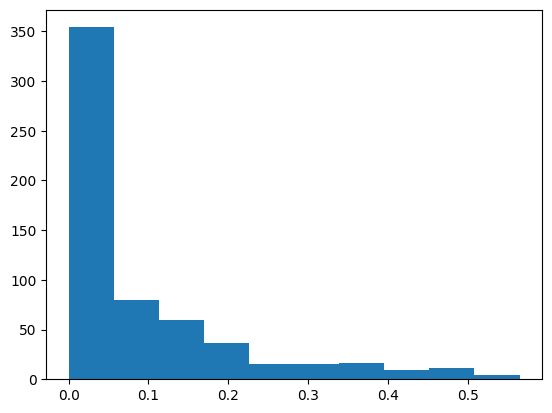

In [309]:
plt.hist(pops19[0].get_x()[:,2000])

In [313]:
with open('results/240829_M3/checkpoint_ABR2_2.dat', 'rb') as file:
    pops = pickle.load(file)

with open('results/240829_M3/bounds_ABR2_2.dat', 'rb') as file:
    all_lower,all_upper = pickle.load(file)

with open('results/240829_M3/240828_train_myprob.obj', 'rb') as file:
    train_myprob = pickle.load(file)

train_myprob.set_bounds(all_upper[-1],all_lower[-1])

In [314]:
train_myprob._setup_rr()

In [347]:
export = np.stack([np.squeeze(train_myprob.current_results[0][k][[np.arange(0,1000,10)],:]) for k in train_myprob.data[0].keys()])
with open('results_M3.dat', 'wb') as file:
    pickle.dump(export, file)